In [5]:
# Cell 1: Imports
import pandas as pd
import os
from pathlib import Path
import tempfile
from deepfake_eval.loaders import ASVspoof2021DFLoader
from deepfake_eval.path_utils import data_path
from deepfake_eval.utils import convert_asvspoof_scores_txt_to_pkl

In [7]:
# Cell 2: Configuration, Conversion, Load Data, Calculate EER, and Clean Up
MODEL_NAME = "SSL_Anti-spoofing"
DATASET_NAME = "ASVspoof2021 DF"

# Paths
TXT_SCORE_FILE_PATH = data_path("scores", "ssl", "ssl_asvspoof2021DF_scores.txt")
AUDIO_DIR_PREFIX = "ASVspoof2021_DF_eval/flac"

# Create a temporary file for the PKL
with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as temp_file:
    TEMP_PKL_PATH = temp_file.name

try:
    # Convert TXT to temporary PKL
    convert_asvspoof_scores_txt_to_pkl(
        txt_score_file_path=str(TXT_SCORE_FILE_PATH),
        output_pkl_path=TEMP_PKL_PATH,
        audio_dir_prefix=AUDIO_DIR_PREFIX
    )
    
    # Load data using the temporary PKL
    loader = ASVspoof2021DFLoader.from_pkl_dict(
        score_pkl=TEMP_PKL_PATH,
        model_name=MODEL_NAME
    )
    df_scores = loader.to_dataframe()
    
    # Calculate EER and metrics
    print(f"Calculating EER for {MODEL_NAME} on {DATASET_NAME}...\n")
    
    eer, eer_threshold = loader.eer()
    CALIBRATED_THRESHOLD = eer_threshold
    
    num_bonafide = (df_scores['df_class'] == 'bonafide').sum()
    num_spoof = (df_scores['df_class'] == 'spoof').sum()
    
    print(f"--- Calibration Results ---")
    print(f"Model: {MODEL_NAME}")
    print(f"Dataset: {DATASET_NAME}")
    print(f"EER: {eer:.4f} (i.e., {eer*100:.2f}%)")
    print(f"Threshold for EER: {CALIBRATED_THRESHOLD:.4f}")
    print(f"Number of bona fide samples: {num_bonafide}")
    print(f"Number of spoof samples: {num_spoof}")
    print(f"---------------------------")
    print(f"\nCalibrated threshold for {MODEL_NAME} on {DATASET_NAME} is: {CALIBRATED_THRESHOLD:.4f}")

except Exception as e:
    print(f"Error: {e}")
    
finally:
    # Clean up the temporary file
    if os.path.exists(TEMP_PKL_PATH):
        os.remove(TEMP_PKL_PATH)

Reading TXT score file: /home/rvirgilli/Projects/voice-deepfake-detection-br/data/scores/ssl/ssl_asvspoof2021DF_scores.txt
Found 611829 scores. Saving to PKL: /tmp/tmp5u23n_ah.pkl
Successfully converted and saved to /tmp/tmp5u23n_ah.pkl


Building records 2021 DF: 100%|██████████| 533928/533928 [00:04<00:00, 115177.95it/s]


Calculating EER for SSL_Anti-spoofing on ASVspoof2021 DF...

--- Calibration Results ---
Model: SSL_Anti-spoofing
Dataset: ASVspoof2021 DF
EER: 0.0285 (i.e., 2.85%)
Threshold for EER: -3.5327
Number of bona fide samples: 14869
Number of spoof samples: 519059
---------------------------

Calibrated threshold for SSL_Anti-spoofing on ASVspoof2021 DF is: -3.5327


/tmp/ipykernel_189615/3822249454.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Classe")


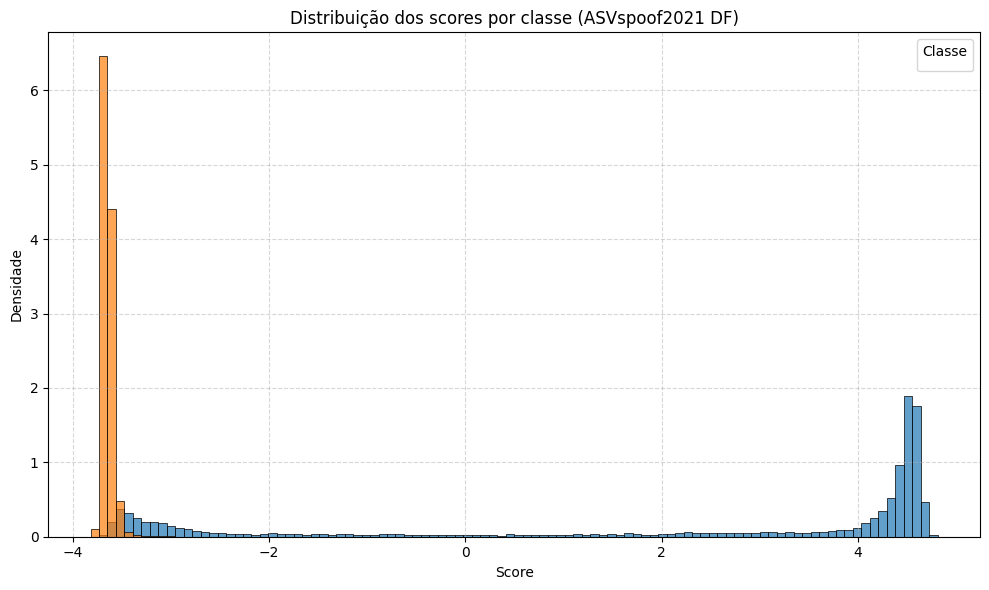

In [ ]:
# Cell 3: Plot da distribuição dos scores por classe

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_scores, 
    x="score", 
    hue="df_class", 
    bins=100, 
    stat="density", 
    common_norm=False, 
    palette={"bonafide": "tab:blue", "spoof": "tab:orange"},
    alpha=0.7
)
plt.title("Distribuição dos scores por classe (ASVspoof2021 DF)")
plt.xlabel("Score")
plt.ylabel("Densidade")
plt.legend(title="Classe")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_189615/1130645268.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Conjunto")


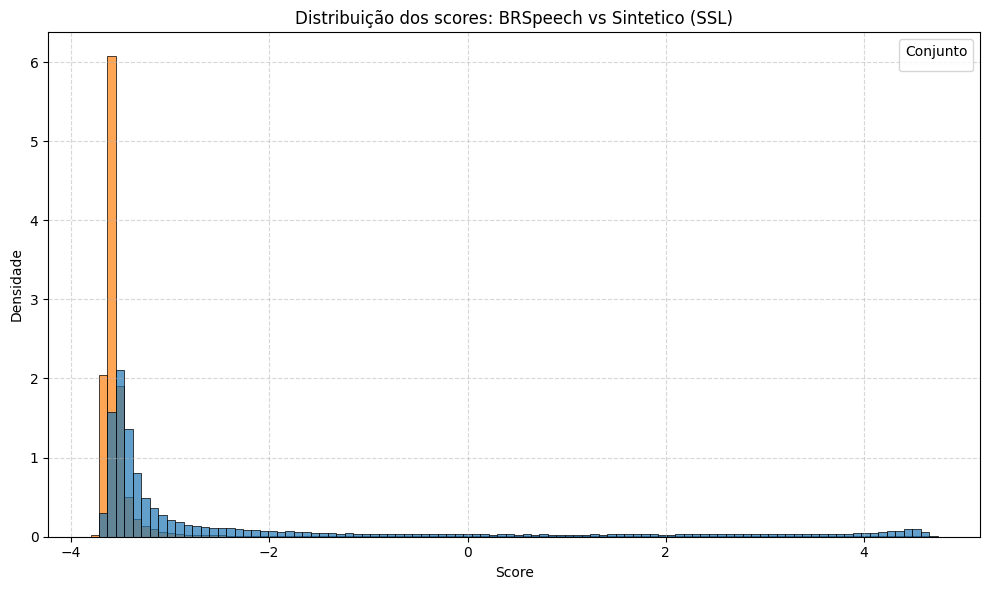

In [9]:
# Cell X: Plot score distributions for BRSpeech and Sintetico (SSL)

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Caminhos dos arquivos PKL
brspeech_pkl = data_path("scores", "ssl", "ssl_brspeech_full_scores.pkl")
sintetico_pkl = data_path("scores", "ssl", "ssl_sintetico_full_scores.pkl")

# Função para carregar os scores de um PKL
def load_scores_from_pkl(pkl_path, label):
    with open(pkl_path, "rb") as f:
        d = pickle.load(f)
    return pd.DataFrame({
        "score": list(d.values()),
        "set": label
    })

# Carregar os DataFrames
df_brspeech = load_scores_from_pkl(brspeech_pkl, "BRSpeech")
df_sintetico = load_scores_from_pkl(sintetico_pkl, "Sintetico")

# Concatenar para plotar juntos
df_all = pd.concat([df_brspeech, df_sintetico], ignore_index=True)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_all,
    x="score",
    hue="set",
    bins=100,
    stat="density",
    common_norm=False,
    palette={"BRSpeech": "tab:blue", "Sintetico": "tab:orange"},
    alpha=0.7
)
plt.title("Distribuição dos scores: BRSpeech vs Sintetico (SSL)")
plt.xlabel("Score")
plt.ylabel("Densidade")
plt.legend(title="Conjunto")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()